# Optimization Tutorial

Trey V. Wenger (c) July 2025

Here we demonstrate how to optimize the number of cloud components in a `HFSRatioModel` model.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pytensor
print("pytensor version:", pytensor.__version__)

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_hfs
print("bayes_hfs version:", bayes_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.30.3
pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_hfs version: 1+0.gc6f9e00.dirty


## Preparing Molecule Data

In [2]:
from bayes_hfs import get_molecule_data, supplement_molecule_data
import pickle

try:
    all_mol_data_12CN, all_mol_metadata_12CN = get_molecule_data("CN, v=0,1", fmin=100.0, fmax=200.0)
    with open("mol_data_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_12CN, f)
    with open("mol_metadata_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_12CN, f)
except:
    with open("mol_data_12CN.pkl", "rb") as f:
        all_mol_data_12CN = pickle.load(f)
    with open("mol_metadata_12CN.pkl", "rb") as f:
        all_mol_metadata_12CN = pickle.load(f)

# Keep only Kl = 0 transitions
all_mol_data_12CN = all_mol_data_12CN[all_mol_data_12CN["Kl"] == 0]

# Add GLO
all_mol_data_12CN["GLO"] = 2 * all_mol_data_12CN["F1l"]

try:
    all_mol_data_13CN, all_mol_metadata_13CN = get_molecule_data("C-13-N", fmin=100.0, fmax=200.0)
    with open("mol_data_13CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_13CN, f)
    with open("mol_metadata_13CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_13CN, f)
except:
    with open("mol_data_13CN.pkl", "rb") as f:
        all_mol_data_13CN = pickle.load(f)
    with open("mol_metadata_13CN.pkl", "rb") as f:
        all_mol_metadata_13CN = pickle.load(f)

# Add GLO
all_mol_data_13CN["GLO"] = 2 * all_mol_data_13CN["F1l"] + 1

mol_data_12CN = supplement_molecule_data(all_mol_data_12CN, all_mol_metadata_12CN)
mol_data_13CN = supplement_molecule_data(all_mol_data_13CN, all_mol_metadata_13CN)

## Model Definition and Simulated Data

In [3]:
from bayes_spec import SpecData
from bayes_hfs import HFSRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108770.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# association each dataset with the related species
mol_keys = {
    "12CN": ["12CN-1", "12CN-2"],
    "13CN": ["13CN-1", "13CN-2"],
}

In [4]:
from bayes_hfs import HFSRatioModel
from bayes_hfs import physics

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = HFSRatioModel(
    mol_data_12CN, # molecular data for species 1
    mol_data_13CN, # molecular data for species 2
    mol_keys, # dataset association
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot1 = [13.5, 0.5], # mean and width of log10 total column density prior of first species (cm-2)
    prior_ratio = 0.1, # width of the column density ratio between the second and first species
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX1 = False, # do not assume CTEX for the first species
    assume_CTEX2 = False, # assume CTEX for the second species for speed
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

sim_params = {
    "log10_Ntot_12CN": np.array([13.8, 13.9, 14.0]),
    "ratio": np.array([1.0/65.0, 1.0/60.0, 1.0/55.0]),
    "fwhm2": np.array([1.0, 1.25, 1.5])**2.0,
    "velocity": [-2.0, 0.0, 2.5],
    "log10_Tex_CTEX": np.log10([4.46, 3.98, 3.16]),
    "log10_CTEX_variance": np.array([-1.5, -2.0, -3.0]),
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
    "baseline_13CN-1_norm": [0.0],
    "baseline_13CN-2_norm": [0.0],
}

CTEX_weights_12CN = physics.calc_stat_weight(
    model.mol1_data["states"]["deg"][None, :],
    model.mol1_data["states"]["E"][None, :],
    10.0 ** sim_params["log10_Tex_CTEX"][:, None],
).eval()

CTEX_concentration_12CN = (
    len(model.mol1_data["states"]["state"])
    * CTEX_weights_12CN
    / 10.0**sim_params["log10_CTEX_variance"][:, None]
)

from scipy.stats import dirichlet

sim_params["weights_12CN"] = np.stack([
    dirichlet(CTEX_concentration_12CN[i]).rvs()[0] for i in range(n_clouds)
])

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

In [5]:
sim_params

{'log10_Ntot_12CN': array([13.8, 13.9, 14. ]),
 'ratio': array([0.01538462, 0.01666667, 0.01818182]),
 'fwhm2': array([1.    , 1.5625, 2.25  ]),
 'velocity': [-2.0, 0.0, 2.5],
 'log10_Tex_CTEX': array([0.64933486, 0.59988307, 0.49968708]),
 'log10_CTEX_variance': array([-1.5, -2. , -3. ]),
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'baseline_13CN-1_norm': [0.0],
 'baseline_13CN-2_norm': [0.0],
 'weights_12CN': array([[0.18099997, 0.35774445, 0.05141127, 0.10060146, 0.04239329,
         0.11086714, 0.15598241],
        [0.18391739, 0.37538564, 0.05147776, 0.0953406 , 0.04756006,
         0.09716964, 0.14914891],
        [0.22015952, 0.43069068, 0.03831167, 0.07664031, 0.03802426,
         0.07752001, 0.11865354]]),
 'log10_Ntot_13CN': array([11.98708664, 12.12184875, 12.25963731]),
 'CTEX_weights_12CN': array([[1.99954842, 4.        , 0.59193533, 1.18327051, 0.58954346,
         1.17923313, 1.76919492],
        [1.99949396, 4.        , 0.51109864, 1.02161662, 0.508

## `Optimize`

We use the `Optimize` class for optimization.

In [6]:
from bayes_spec import Optimize
from bayes_hfs import HFSRatioModel

# Initialize optimizer
opt = Optimize(
    HFSRatioModel,
    mol_data_12CN, # molecular data for species 1
    mol_data_13CN, # molecular data for species 2
    mol_keys, # dataset association
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    max_n_clouds=5,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)

# Define each model
opt.add_priors(
    prior_log10_Ntot1 = [13.5, 0.5], # mean and width of log10 total column density prior of first species (cm-2)
    prior_ratio = 0.1, # width of the column density ratio between the second and first species
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX1 = False, # do not assume CTEX for the first species
    assume_CTEX2 = True, # assume CTEX for the second species for speed
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [7]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. This is generally a bad idea, since VI is only an approximation and tends to struggle with complex models. Instead we use `approx=False` to sample every model with MCMC. This is slower but more robust.

We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model. The algorithm will terminate early if successive models have increasing BICs or fail to converge.

In [8]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.01,
    "learning_rate": 0.001,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 200_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.9},
}
solve_kwargs = {
    "init_params": "random_from_data",
    "n_init": 10,
    "max_iter": 1_000,
    "kl_div_threshold": 0.1,
}
opt.optimize(
    bic_threshold=10.0,
    sample_kwargs=sample_kwargs,
    fit_kwargs=fit_kwargs,
    solve_kwargs=solve_kwargs,
    approx=False,
    start_spread = {"velocity_norm": [0.1, 0.9]},
)

Null hypothesis BIC = 1.132e+07
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 41000
Interrupted at 40,999 [20%]: Average Loss = 1.8552e+17
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1162 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.335e+06

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 45400
Interrupted at 45,399 [22%]: Average Loss = 7.3459e+19
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5737 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 6.866e+05

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 56200
Interrupted at 56,199 [28%]: Average Loss = 4.8623e+28
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1155 seconds.


Adding log-likelihood to trace


Output()

There were 990 divergences in converged chains.
GMM converged to unique solution
6 of 8 chains appear converged.
n_cloud = 3 solution = 0 BIC = -1.277e+04

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 65600
Interrupted at 65,599 [32%]: Average Loss = 7.3701e+21
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5104 seconds.


Adding log-likelihood to trace


Output()

There were 330 divergences in converged chains.
GMM found 3 unique solutions
Solution 0: chains [np.int64(0), np.int64(1)]
Solution 1: chains [np.int64(3), np.int64(6), np.int64(7)]
Solution 2: chains [np.int64(4), np.int64(5)]
7 of 8 chains appear converged.
n_cloud = 4 solution = 0 BIC = -1.267e+04
n_cloud = 4 solution = 1 BIC = -1.267e+04
n_cloud = 4 solution = 2 BIC = -1.267e+04

Stopping criteria met.
Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 76300
Interrupted at 76,299 [38%]: Average Loss = 7.9475e+24
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6427 seconds.


Adding log-likelihood to trace


Output()

There were 271 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Stopping criteria met.
Stopping early.


In [9]:
opt.best_model.n_clouds

3

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

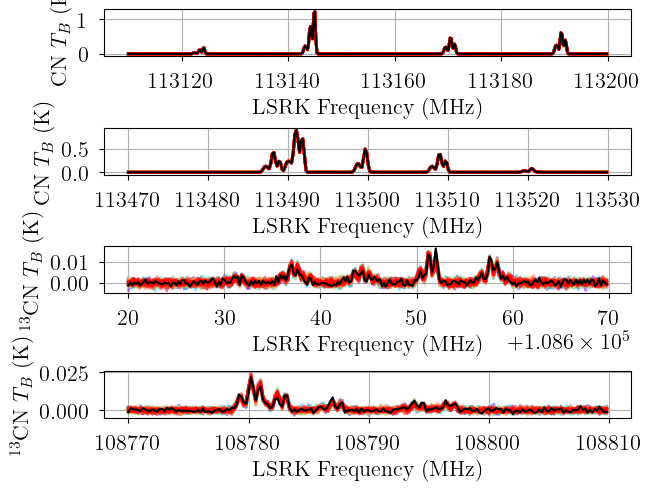

In [12]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)

Text(0, 0.5, 'BIC')

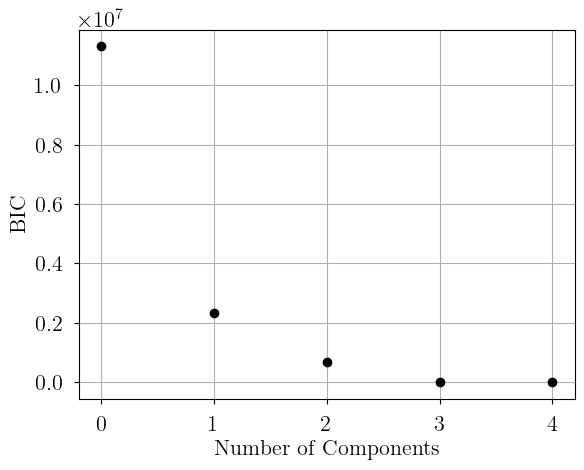

In [13]:
plt.plot(opt.bics.keys(), opt.bics.values(), 'ko')
plt.xlabel("Number of Components")
plt.ylabel("BIC")